In [319]:
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Stats packages
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# Packages for date conversions for calculating trip durations
import datetime

# Packages for OLS, MLR, confusion matrix
import sklearn.metrics as metrics # For confusion matrix
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [320]:
df0=pd.read_csv('../Data Sources/taxi_nov_2025.csv') 

In [321]:
df0.info()
df0.shape

<class 'pandas.DataFrame'>
RangeIndex: 4181444 entries, 0 to 4181443
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   str    
 1   tpep_dropoff_datetime  str    
 2   trip_distance          float64
 3   RatecodeID             float64
 4   PULocationID           int64  
 5   DOLocationID           int64  
 6   payment_type           int64  
 7   fare_amount            float64
 8   VendorID               int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 438.7 MB


(4181444, 9)

In [322]:
df0.drop_duplicates()
df0.isna().astype(int).sum()

tpep_pickup_datetime           0
tpep_dropoff_datetime          0
trip_distance                  0
RatecodeID               1014740
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
VendorID                       0
dtype: int64

Selecting Vendor == 1 for further analysis

In [323]:
df0 = df0[df0['VendorID']==1]
df0['RatecodeID'] = df0['RatecodeID'].fillna(99)

In [324]:
df0.info()

<class 'pandas.DataFrame'>
Index: 821333 entries, 2 to 4181442
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   tpep_pickup_datetime   821333 non-null  str    
 1   tpep_dropoff_datetime  821333 non-null  str    
 2   trip_distance          821333 non-null  float64
 3   RatecodeID             821333 non-null  float64
 4   PULocationID           821333 non-null  int64  
 5   DOLocationID           821333 non-null  int64  
 6   payment_type           821333 non-null  int64  
 7   fare_amount            821333 non-null  float64
 8   VendorID               821333 non-null  int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 92.6 MB


In [325]:
df0['tpep_pickup_datetime'] = pd.to_datetime(df0['tpep_pickup_datetime'])
df0['tpep_dropoff_datetime'] = pd.to_datetime(df0['tpep_dropoff_datetime'])

In [326]:

df0.describe().round(2)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,VendorID
count,821333,821333,821333.00,821333.00,821333.00,821333.00,821333.00,821333.00,821333.0
mean,2025-11-15 08:33:56.283478,2025-11-15 08:55:29.379935,3.75,30.51,161.15,160.32,0.95,20.53,1.0
min,2025-11-01 00:00:03,2025-11-01 00:00:51,0.00,1.00,1.00,1.00,0.00,0.00,1.0
25%,2025-11-07 21:51:34,2025-11-07 22:10:08,1.10,1.00,113.00,107.00,1.00,10.00,1.0
50%,2025-11-15 08:17:03,2025-11-15 08:37:53,2.00,1.00,161.00,162.00,1.00,15.60,1.0
75%,2025-11-22 02:10:01,2025-11-22 02:22:17,4.30,99.00,234.00,234.00,1.00,26.10,1.0
max,2025-11-30 23:59:59,2025-12-01 21:41:00,222.30,99.00,265.00,265.00,4.00,1272.80,1.0
std,NaN,NaN,4.54,44.91,68.36,71.43,0.59,16.05,0.0


Adding trip duration in minutes

In [327]:
df0['duration'] = df0['tpep_dropoff_datetime'] - df0['tpep_pickup_datetime']
df0['duration'] = df0['duration'].dt.total_seconds() / 60

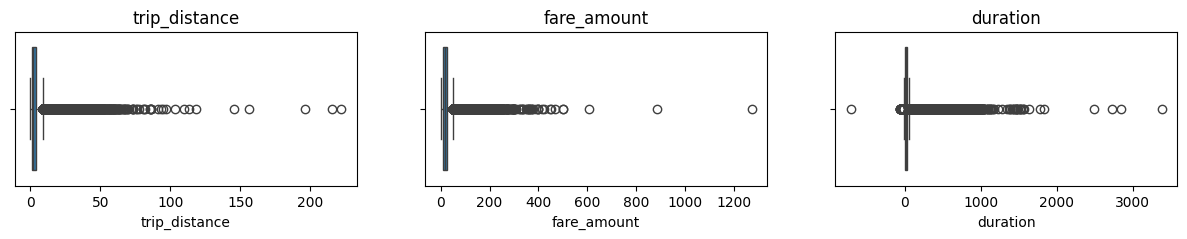

In [328]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))

sns.boxplot(ax=axes[0],x=df0['trip_distance'])
axes[0].set_title('trip_distance')

sns.boxplot(ax=axes[1],x=df0['fare_amount'])
axes[1].set_title('fare_amount')

sns.boxplot(ax=axes[2],x=df0['duration'])
axes[2].set_title('duration')

plt.show()

In [329]:

df0[df0['trip_distance']<=0]['trip_distance'].count()

np.int64(10538)

In [330]:
df0[df0['fare_amount']<=0]['fare_amount'].count()

np.int64(479)

In [331]:
df1 = df0.copy()

df1 = df0[(df0['fare_amount']>0)&(df0['trip_distance']>0)]

Outlier handling function

In [332]:
def outlier_capping(df, column_list, iqr_factor=1.5):
    '''
     Function is inputting upper-limit values in specified columns based on their interquartile range.

    '''
    for col in column_list:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            upper_limit = Q3 + iqr_factor * IQR
            df[col] = df[col].clip(upper=upper_limit)

Based on previous check we need to handle high values in fare amount and duration columns

In [333]:
outlier_capping(df1, ['fare_amount', 'duration', 'trip_distance'], iqr_factor=6)

In [334]:
df1.describe().round()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,VendorID,duration
count,810561,810561,810561.0,810561.0,810561.0,810561.0,810561.0,810561.0,810561.0,810561.0
mean,2025-11-15 08:37:30.558906,2025-11-15 08:59:09.153195,4.0,31.0,161.0,160.0,1.0,21.0,1.0,21.0
min,2025-11-01 00:00:03,2025-11-01 00:04:18,0.0,1.0,1.0,1.0,0.0,0.0,1.0,-707.0
25%,2025-11-07 21:54:34,2025-11-07 22:13:03,1.0,1.0,113.0,107.0,1.0,10.0,1.0,9.0
50%,2025-11-15 08:29:53,2025-11-15 08:50:15,2.0,1.0,161.0,162.0,1.0,16.0,1.0,15.0
75%,2025-11-22 02:08:28,2025-11-22 02:21:28,4.0,99.0,234.0,234.0,1.0,26.0,1.0,26.0
max,2025-11-30 23:59:59,2025-12-01 21:41:00,24.0,99.0,265.0,265.0,4.0,123.0,1.0,128.0
std,NaN,NaN,4.0,45.0,68.0,71.0,1.0,15.0,0.0,19.0


The duration column has problematic values at both the lower and upper extremities.

Low values: There should be no values that represent negative time. Thus we impute all negative durations with 0

In [335]:
df1= df1[df1['duration']>=0]

In [336]:
df1.describe(include=['number']).round()


,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,VendorID,duration
count,810239.0,810239.0,810239.0,810239.0,810239.0,810239.0,810239.0,810239.0
mean,4.0,31.0,161.0,160.0,1.0,21.0,1.0,21.0
std,4.0,45.0,68.0,71.0,1.0,15.0,0.0,19.0
min,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
25%,1.0,1.0,113.0,107.0,1.0,10.0,1.0,9.0
50%,2.0,1.0,161.0,162.0,1.0,16.0,1.0,15.0
75%,4.0,99.0,234.0,234.0,1.0,26.0,1.0,26.0
max,24.0,99.0,265.0,265.0,4.0,123.0,1.0,128.0


**Feature enginering**

In [337]:
df1['pickup_dropoff'] = df1['PULocationID'].astype(str) + " " + df1['DOLocationID'].astype(str)
grouped = df1.groupby(['pickup_dropoff'])['trip_distance'].mean()

grouped_dict = grouped.to_dict() 
df1['mean_distance'] = df1['pickup_dropoff']

df1['mean_distance'] = df1['mean_distance'].map(grouped_dict)

df1.head()


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,VendorID,duration,pickup_dropoff,mean_distance
2,2025-11-01 00:07:19,2025-11-01 00:20:41,2.7,1.0,163,238,1,15.6,1,13.366667,163 238,2.270776
4,2025-11-01 00:18:50,2025-11-01 00:49:32,8.4,1.0,138,37,2,39.4,1,30.700000,138 37,8.685106
10,2025-11-01 00:00:03,2025-11-01 00:42:25,3.3,1.0,158,88,1,35.9,1,42.366667,158 88,2.872917
11,2025-11-01 00:43:53,2025-11-01 00:56:46,1.5,1.0,88,148,1,12.8,1,12.883333,88 148,2.237705
12,2025-11-01 00:58:02,2025-11-01 01:32:36,4.7,1.0,148,236,1,32.4,1,34.566667,148 236,5.419753


In [338]:
groupped_duration = df1.groupby('pickup_dropoff')['duration'].mean()

duration_dict = groupped_duration.to_dict() 
duration_dict

df1['mean_duration'] = df1['pickup_dropoff']
df1['mean_duration'] = df1['mean_duration'].map(duration_dict)

df1['mean_duration'].describe()


count    810239.000000
mean         21.325813
std          16.987519
min           0.083333
25%          10.171153
50%          15.647982
75%          25.461111
max         128.333333
Name: mean_duration, dtype: float64

In [339]:
df1[(df1['PULocationID']==100) & (df1['DOLocationID']==231)][['mean_duration']]

,mean_duration
5530,21.768194
92718,21.768194
143573,21.768194
169918,21.768194
205411,21.768194
...,...
3942054,21.768194
3984844,21.768194
4106924,21.768194
4107465,21.768194


In [340]:
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name()
df1['month'] = df1['tpep_pickup_datetime'].dt.month_name()

In [341]:
df1['rush_hour'] = np.where(((df1['tpep_pickup_datetime'].dt.hour>=6) & 
                            (df1['tpep_pickup_datetime'].dt.hour<10)) | 
                            ((df1['tpep_pickup_datetime'].dt.hour>=16) &
                            (df1['tpep_pickup_datetime'].dt.hour<20)), 1, 0)

df1.loc[df1['day'].isin(['Saturday', 'Sunday']), 'rush_hour'] = 0
df1.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,VendorID,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
2,2025-11-01 00:07:19,2025-11-01 00:20:41,2.7,1.0,163,238,1,15.6,1,13.366667,163 238,2.270776,14.411492,Saturday,November,0
4,2025-11-01 00:18:50,2025-11-01 00:49:32,8.4,1.0,138,37,2,39.4,1,30.700000,138 37,8.685106,27.763830,Saturday,November,0
10,2025-11-01 00:00:03,2025-11-01 00:42:25,3.3,1.0,158,88,1,35.9,1,42.366667,158 88,2.872917,16.550347,Saturday,November,0
11,2025-11-01 00:43:53,2025-11-01 00:56:46,1.5,1.0,88,148,1,12.8,1,12.883333,88 148,2.237705,12.989071,Saturday,November,0
12,2025-11-01 00:58:02,2025-11-01 01:32:36,4.7,1.0,148,236,1,32.4,1,34.566667,148 236,5.419753,24.268724,Saturday,November,0


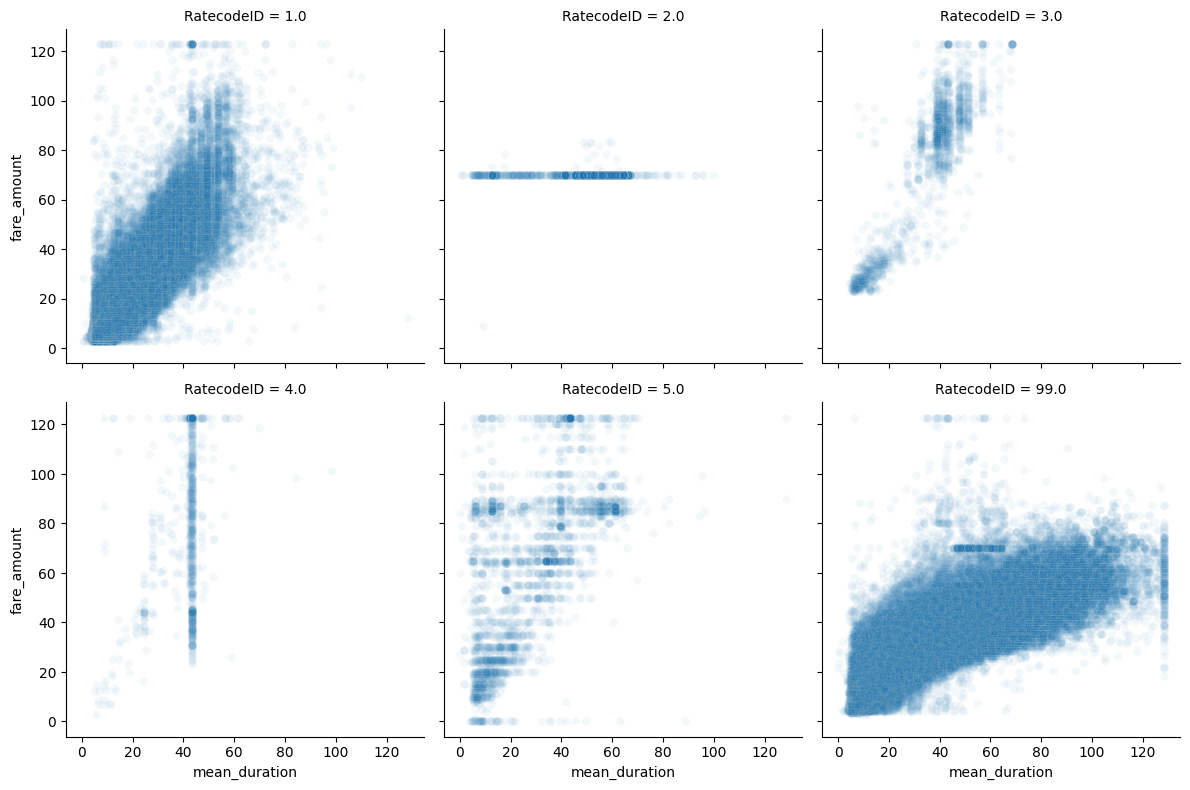

In [342]:
g = sns.relplot(
    data=df1[(df1['RatecodeID'].isin([1, 2, 3, 4, 5, 99]))|(df1['RatecodeID'].isna())],
    x="mean_duration",   
    y="fare_amount",
    col="RatecodeID",     
    col_wrap=3,         
    kind="scatter",
    alpha=0.05,            
    height=4, 
    aspect=1
)

/Users/annaviniichuk/Documents/Python/.venv/lib/python3.13/site-packages/IPython/core/events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/annaviniichuk/Documents/Python/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


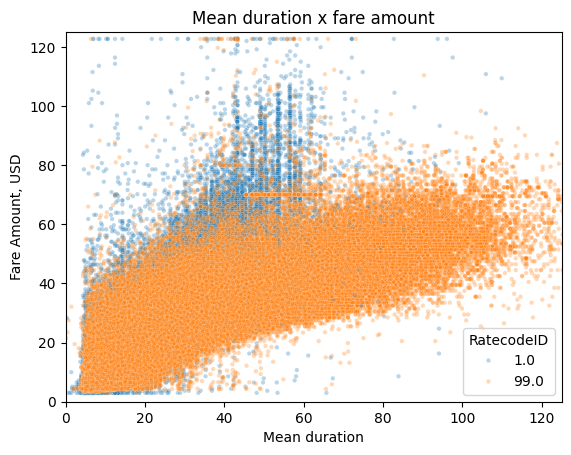

In [343]:
mask = (df1['RatecodeID'].isin([1,99])) 
sns.scatterplot(x=df1[mask]['mean_duration'], y=df1[mask]['fare_amount']
    , alpha=0.3, s=10, hue=df1[mask]['RatecodeID'].astype(str))
plt.xlabel('Mean duration')
plt.ylabel('Fare Amount, USD')
plt.ylim(0, 125)
plt.xlim(0, 125)
plt.title('Mean duration x fare amount')
ax.grid(True, linestyle='--', alpha=0.05)

(0.0, 125.0)

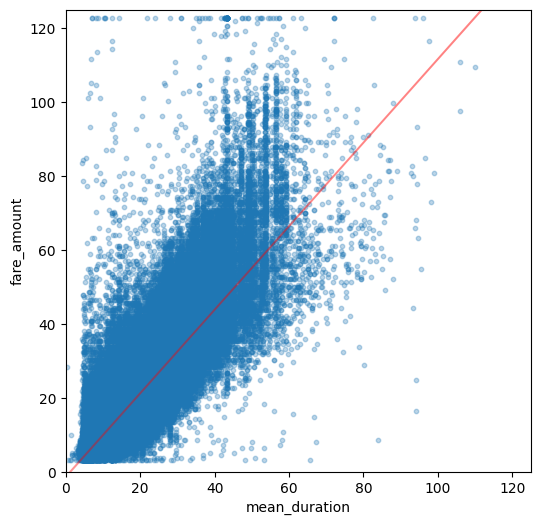

In [344]:
mask_one_ratecode = (df1['RatecodeID'].isin([1])) 
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(
    data=df1[mask_one_ratecode], 
    x='mean_duration', 
    y='fare_amount',
    scatter_kws={'alpha': 0.3, 's': 10} ,
    truncate=True,
    line_kws={'color': 'red', 'lw': 1.5,  'alpha': 0.4}
)
plt.ylim(0, 125)
plt.xlim(0, 125)

In [345]:
pd.set_option('display.max_columns', None)
df1[df1['fare_amount']==52].head(30)

print(f"{(df1[df1['fare_amount'] == 52]['fare_amount'].count() / df1.shape[0]) * 100:.2f}%")

0.07%


Mean duration and fare amount have visible strong correlation. Hovewer, there 2 horisontal lines around 52 USD and 63 USD. Dataset contains 2% trips with flat fare.
It seems those are trips from/to JFK airoport and probably they have fix fare in 2017 of $52. The second line was created after addressing outliers; all values above the 99.9th percentile were imputed as 63 USD

In [346]:
df2 = df1[['RatecodeID', 'fare_amount', 'VendorID', 
          'mean_distance', 'mean_duration', 'day', 'rush_hour']]
df2 = df2[df2['RatecodeID'].isin([1,99])]

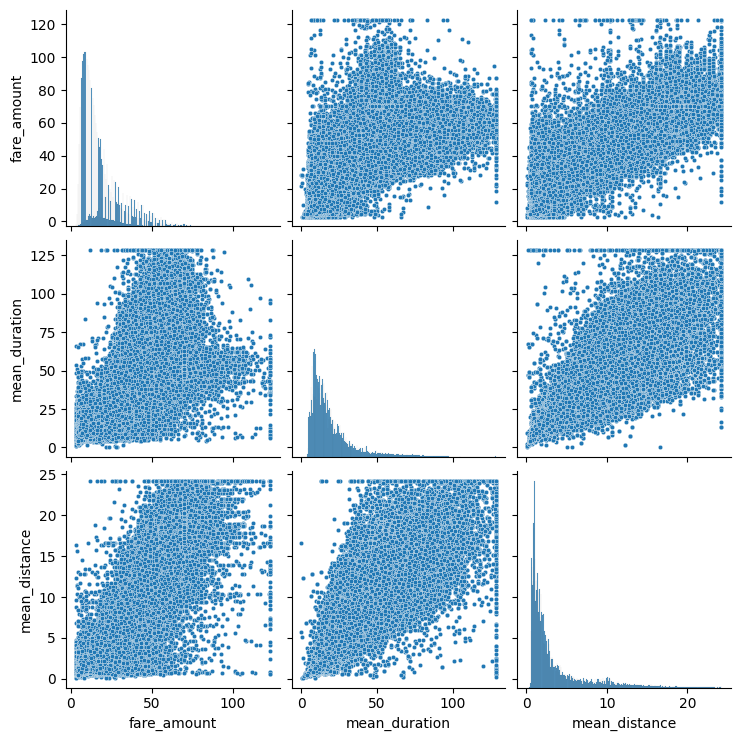

In [347]:
sns.pairplot(df2[['fare_amount', 'mean_duration', 'mean_distance']], plot_kws={'s': 10})

In [348]:
df2.corr(method='pearson', numeric_only=True)

,RatecodeID,fare_amount,VendorID,mean_distance,mean_duration,rush_hour
RatecodeID,1.000000,0.408919,NaN,0.437396,0.499385,0.033199
fare_amount,0.408919,1.000000,NaN,0.902305,0.837717,0.026401
VendorID,NaN,NaN,NaN,NaN,NaN,NaN
mean_distance,0.437396,0.902305,NaN,1.000000,0.905810,0.020396
mean_duration,0.499385,0.837717,NaN,0.905810,1.000000,0.042765
rush_hour,0.033199,0.026401,NaN,0.020396,0.042765,1.000000


Fare amount highly correlates with mean distance and mean trip duration, 0.91 & 0.86 respectfully

Text(0.5, 1.0, 'Correlation heatmap')

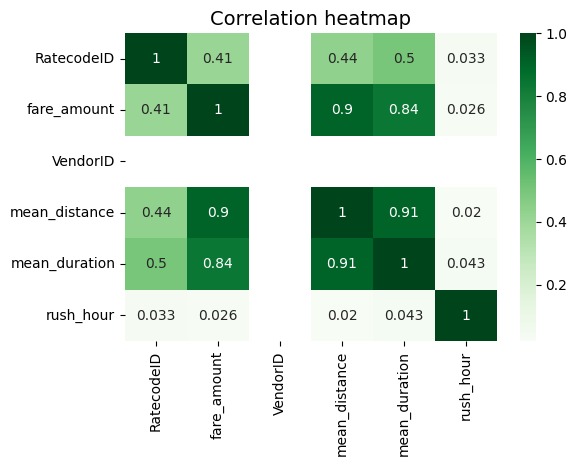

In [349]:
plt.figure(figsize=(6,4))
sns.heatmap(df2.corr(method='pearson', numeric_only=True), annot=True, cmap='Greens')
plt.title("Correlation heatmap", fontsize=14)

In [350]:
X = df2[df2['RatecodeID'].isin([1,99])].drop(columns='fare_amount')
y = df2[df2['RatecodeID'].isin([1,99])]['fare_amount']
X.head()

,RatecodeID,VendorID,mean_distance,mean_duration,day,rush_hour
2,1.0,1,2.270776,14.411492,Saturday,0
4,1.0,1,8.685106,27.763830,Saturday,0
10,1.0,1,2.872917,16.550347,Saturday,0
11,1.0,1,2.237705,12.989071,Saturday,0
12,1.0,1,5.419753,24.268724,Saturday,0


Creating dummy variables for RatecodeID & weekday

In [351]:
X['RatecodeID'] = X['RatecodeID'].astype(int).astype(str)
X = pd.get_dummies(X, columns=['RatecodeID','day'], drop_first=True).astype(int)
X['duration_ratecode'] = X['mean_duration'] * X['RatecodeID_99']
X.head()


,VendorID,mean_distance,mean_duration,rush_hour,RatecodeID_99,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,duration_ratecode
2,1,2,14,0,0,0,1,0,0,0,0,0
4,1,8,27,0,0,0,1,0,0,0,0,0
10,1,2,16,0,0,0,1,0,0,0,0,0
11,1,2,12,0,0,0,1,0,0,0,0,0
12,1,5,24,0,0,0,1,0,0,0,0,0


Check for Model assumptions:  

**Multicolinearity** occurs when two or more independent variables (predictors) in a regression model are highly correlated with each other. This means they provide redundant information, making it difficult for the model to determine the individual effect of each variable on the outcome.  

Here we will use VIF (variance inflation factor) for predictors.

In [352]:
X = X[['mean_distance', 'mean_duration', 'rush_hour', 'RatecodeID_99', 'duration_ratecode', 'day_Wednesday',
        'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday']]
X['intercept'] = 1

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data.sort_values(by="VIF", ascending=False))

              feature        VIF
11          intercept  14.799068
1       mean_duration  13.094050
4   duration_ratecode  10.898003
0       mean_distance   5.851650
3       RatecodeID_99   3.514461
7        day_Saturday   2.010123
8          day_Sunday   1.894594
5       day_Wednesday   1.762959
10        day_Tuesday   1.748483
9        day_Thursday   1.745650
6          day_Monday   1.729113
2           rush_hour   1.242466


All predictors have VIF less than threshold of 5. While distance and duration are strongly correlated (r=0.85), VIF analysis confirms they provide distinct, stable contributions to the fare calculation

Next step is to split dataset to train and test. In this case it will be 20% for test.

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

Standartization of predictors

In [354]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

print('X_train scaled:', X_train_scaled)

X_train scaled: [[-0.52380873 -0.49824649 -0.65114748 ... -0.40073343 -0.40090051
   0.        ]
 [-0.7854544  -0.86189692 -0.65114748 ... -0.40073343 -0.40090051
   0.        ]
 [-0.52380873 -0.6194633  -0.65114748 ...  2.49542444 -0.40090051
   0.        ]
 ...
 [ 2.61593933  2.9564326  -0.65114748 ...  2.49542444 -0.40090051
   0.        ]
 [-0.7854544  -0.80128852 -0.65114748 ... -0.40073343 -0.40090051
   0.        ]
 [ 0.52277395  0.41087959 -0.65114748 ... -0.40073343  2.49438444
   0.        ]]


**Model fit**

In [355]:
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


**Model evaluation**

In [356]:
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.8533091301965373
R^2: 0.8533091301965373
MAE: 3.447148047755104
MSE: 25.739888532493815
RMSE: 5.073449372221409


In [357]:
X_test_scaled = scaler.transform(X_test)

In [358]:
r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.8547764489015406
R^2: 0.8547764489015406
MAE: 3.4306448183192306
MSE: 25.266754352071192
RMSE: 5.0266046544433145


Model explains 85% of the variance in fare amounts. On average, our predictions are off by about 2.20 USD.  
Root Mean Square Error is higher than MAE (4.04$ vs 2.20$) meaning that we have high outliers - mosl likely those 52 USD and  63 USD values. 

In [359]:
results = pd.DataFrame(data = {"actual": y_test,
                              "predicted": y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
608348,7.2,7.412656,-0.212656
1690905,17.0,21.816561,-4.816561
206614,10.7,10.394036,0.305964
1604146,19.1,15.237053,3.862947
2638107,7.2,5.525460,1.674540


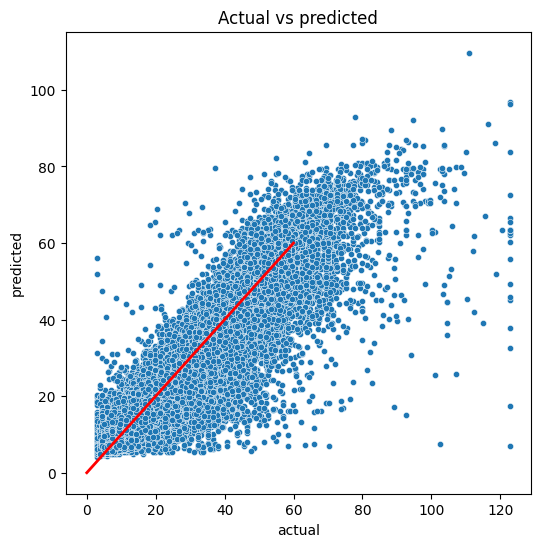

In [360]:
fig, ax = plt.subplots(figsize=(6,6)) 
sns.scatterplot(x='actual', y='predicted', data=results, s=20)
ax.set_title("Actual vs predicted")

plt.plot([0,60], [0,60], c='red', linewidth=2)

Text(0.5, 1.0, 'Residuals distribution')

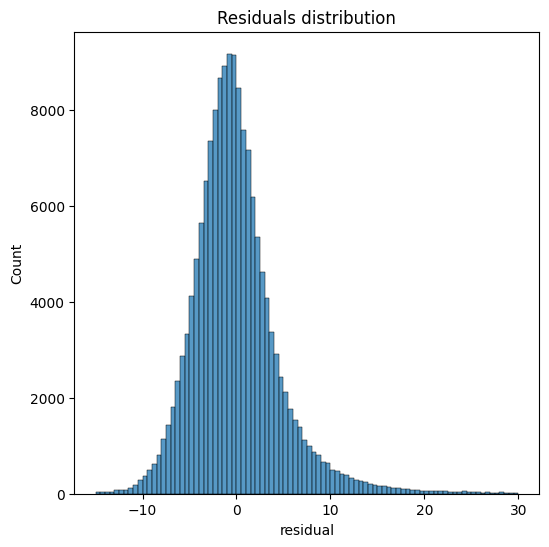

In [361]:
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(results['residual'], bins=np.arange(-15,30.5,0.5))
ax.set_title("Residuals distribution")

In [362]:
print(results['residual'].mean())

-0.015049259390469874


Text(0.5, 1.0, 'Residuals vs Predicted values')

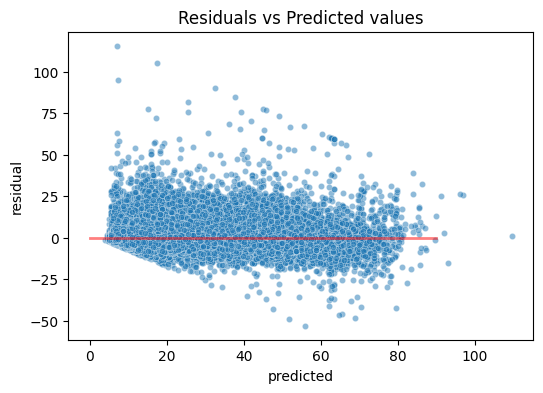

In [363]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot( x='predicted', y='residual', data=results, s=20, alpha=0.5)
plt.plot([0,90], [0,0], c='red', linewidth=2, alpha=0.5)
ax.set_title("Residuals vs Predicted values")

In [364]:
coefficients = pd.DataFrame(lr.coef_.flatten(), index=X.columns, columns=['Coefficient'])
coefficients

stds = scaler.scale_

original_units_coef = lr.coef_.flatten() / stds

stakeholder_summary = pd.DataFrame({
    'Feature': X.columns,
    'Impact_per_Unit': original_units_coef
})
print(stakeholder_summary)

base_fare = lr.intercept_ - np.sum(original_units_coef * scaler.mean_)

print(f"The starting base fare is: ${base_fare:.2f}")

              Feature  Impact_per_Unit
0       mean_distance         2.284102
1       mean_duration         0.527255
2           rush_hour         0.033244
3       RatecodeID_99         8.432105
4   duration_ratecode        -0.441470
5       day_Wednesday         0.739255
6          day_Monday        -0.179445
7        day_Saturday        -0.100286
8          day_Sunday        -0.725259
9        day_Thursday         0.653241
10        day_Tuesday         0.539116
11          intercept         0.000000
The starting base fare is: $3.56


The highest impact on the fare amount has mean distance, with in crease by 1 mile fare increases by 1.89 USD, duration is also quite impacful +0.30 USD for each additional minute of the trip.  

During rush hour fare amount usually increased by 0.13 USD.  
It's visible that taxi service has weekly seasonality, Friday price is higher in avg that other day of the week except Thu and Wed. Fare amount during other weekday is lower: Sat (-0.29USD) , Sun (-0.53 USD), Mon (-0.50USD) or Tue (-0.09 USD).

**Model equation**

In [365]:

# Fare = base_fare + ($1.94 * Miles) + ($0.29 * Minutes) + (Day Adjustments) + error

**Prediction on full dataset**

In [366]:
X_scaled = scaler.transform(X)
y_preds_full = lr.predict(X_scaled)

In [367]:
final_preds = df2['RatecodeID'].copy()
final_preds['y_preds_full'] = y_preds_full
 
final_preds.loc['y_preds_full']

final_preds.head()

2     1.0
4     1.0
10    1.0
11    1.0
12    1.0
Name: RatecodeID, dtype: object

In [368]:
final_preds = final_preds['y_preds_full']
print('R^2:', r2_score(y, final_preds))
print('MAE:', mean_absolute_error(y, final_preds))
print('MSE:', mean_squared_error(y, final_preds))
print('RMSE:',np.sqrt(mean_squared_error(y, final_preds)))
# mape = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered)
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

R^2: 0.853601463279561
MAE: 3.4438473977007575
MSE: 25.645261576939863
RMSE: 5.064115083303287


By manually setting those to 52, we removed the biggest source of "noise," allowing the R^2 to climb toward 0.89.  
An MAE decreased to $2.02. The drop in RMSE is from 4.18 to 3.43.

In [369]:
nyc_preds_means = df2[['mean_duration', 'mean_distance', 'fare_amount']].copy()
nyc_preds_means['predicted_fare'] = final_preds
nyc_preds_means['residuals'] = nyc_preds_means['fare_amount'] - final_preds
nyc_preds_means.head()

,mean_duration,mean_distance,fare_amount,predicted_fare,residuals
2,14.411492,2.270776,15.6,15.412133,0.187867
4,27.763830,8.685106,39.4,35.971066,3.428934
10,16.550347,2.872917,35.9,16.466644,19.433356
11,12.989071,2.237705,12.8,14.357622,-1.557622
12,24.268724,5.419753,32.4,27.536994,4.863006


<Axes: xlabel='predicted_fare', ylabel='residuals'>

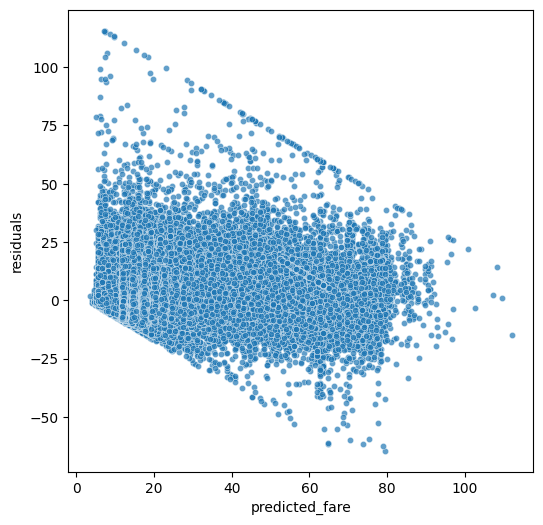

In [370]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x='predicted_fare', y='residuals', data = nyc_preds_means, s=20, alpha = 0.7)